# Import Model

In [1]:
import tensorflow as tf
import tensorflow_hub as tf_hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import re
import ast
import nltk

# Pre-processing & Feature engineering
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,TextVectorization,Reshape
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
from wordcloud import WordCloud

# Modelling
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

# Save Model
import joblib

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
df = pd.read_csv('merged_data_new.csv')

In [3]:
df.head(5)

,Review,Rating
0,"Produk Ok, pengiriman relatif cepat, dan respo...",bintang 5
1,"modelnya pas, keren, bahannya bagus, sdh bbrp ...",bintang 5
2,saya sangat puas banget pengen beli lagi asli,bintang 5
3,"Barang datang sesuai deskripsi,pembelian kedua...",bintang 5
4,"barang sesuai , kualitas bagus buatan Indonesi...",bintang 5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18186 entries, 0 to 18185
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  17925 non-null  object
 1   Rating  18186 non-null  object
dtypes: object(2)
memory usage: 284.3+ KB


In [5]:
df.duplicated().sum()

1781

In [6]:
df = df.drop_duplicates()

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

Review    5
Rating    0
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

# Data Preprocessing

In [11]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('indonesian')))

In [12]:
# Define Stemming
stemmer = StemmerFactory().create_stemmer()

In [13]:
# Open slangwords_indonesian.txt
with open('slangwords_indonesian.txt') as f:
    data = f.read()

slangwords_indonesian =  ast.literal_eval(data)
slangwords_indonesian

{'@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': 'akan',
 'bandes': 'bantuan desa',
 'bangedh': 'banget',
 'banpol': 'bantuan polisi',
 'banpur': 'bantuan tempur',
 'basbang': 'basi',
 'bcanda': 'bercanda',
 'bdg': 'bandung',
 'begajulan': 'nakal',
 'beliin': 'belikan',
 'bencong': 'banci',
 'bentar': 'sebentar',
 'ber3': 'bertiga',
 'b

In [14]:
# Membuat suatu fungsi yang berisi full preprocessing step
def text_preprocessing(text, slangwords_indonesian):
    # Fungsi untuk mengubah teks menjadi huruf kecil
    def lower(text):
        return text.lower()

    # Fungsi untuk mengganti abbreviation
    def check_slang(text):
        temp = []
        for slang in text.split():
            if slang in slangwords_indonesian:
                temp.append(slangwords_indonesian[slang])
            else:
                temp.append(slang)
        return " ".join(temp)

    # Fungsi untuk menghapus tanda baca, newlines, dan whitespace ekstra
    def check_punctuation(text):
        # Non-letter removal (seperti emoticon, symbol (seperti μ, $, 兀), dan lain-lain
        text = re.sub("[^a-zA-Z]", ' ', text)
        # Hashtags removal
        text = re.sub("#[A-Za-z0-9_]+", " ", text)
        # Mention removal
        text = re.sub("@[A-Za-z0-9_]+", " ", text)
        # Menghapus teks yang ada di dalam tanda kurung siku ([...]) dalam document
        text = re.sub('\[[^]]*\]', ' ', text)
        # Mengganti setiap baris baru (newline) dengan spasi
        text = re.sub(r"\\n", " ", text)
        # Menghapus whitespace ekstra di awal dan akhir token
        text = text.strip()
        # Menghapus spasi berlebih di antara kata-kata (hanya menyisakan satu spasi antar kata)
        text = ' '.join(text.split())
        return text

    # Fungsi untuk tokenisasi, menghapus stopwords, dan stemming
    def token_stopwords_stem(text):
        # Tokenization
        tokens = word_tokenize(text)
        # Stopwords removal
        tokens = [word for word in tokens if word not in stpwds_id]
        # Stemming
        tokens = [stemmer.stem(word) for word in tokens]
        # Combining Tokens
        text = ' '.join(tokens)  # Menggunakan 'text' untuk menggabungkan kembali tokens
        return text

    # Proses Preprocessing
    text = lower(text)
    text = check_slang(text)
    text = check_punctuation(text)
    text = token_stopwords_stem(text)
    
    return text

# Target Conversion

In [15]:
# Applying Text Preprocessing to the Dataset
df['Review_processed'] = df['Review'].apply(lambda x: text_preprocessing(x, slangwords_indonesian))
df

,Review,Rating,Review_processed
0,"Produk Ok, pengiriman relatif cepat, dan respo...",bintang 5,produk ok kirim relatif cepat respon jual
1,"modelnya pas, keren, bahannya bagus, sdh bbrp ...",bintang 5,model pas keren bahan bagus sdh bbrp kali beli...
2,saya sangat puas banget pengen beli lagi asli,bintang 5,puas banget ken beli asli
3,"Barang datang sesuai deskripsi,pembelian kedua...",bintang 5,barang sesuai deskripsi beli putus packing rap...
4,"barang sesuai , kualitas bagus buatan Indonesi...",bintang 5,barang sesuai kualitas bagus buat indonesia em...
...,...,...,...
18181,Ada yang mau disumbang sepatu ini? Ga kepake. ...,bintang 1,sumbang sepatu ga kepake jelek
18182,sesuai dengan harga danbdahhhhhhh,bintang 1,sesuai harga danbdahhhhhhh
18183,packing & delivery okay.\r\nseller responsif &...,bintang 1,packing delivery okay seller responsif ramah p...
18184,"Kualitas produk buruk sekali, lubang lubang un...",bintang 1,kualitas produk buruk lubang lubang tali hamoi...


#### Konversi Rating --> Label 0(Negative) dan 1(Positive)

In [16]:
# Menghapus kata 'bintang' pada kolom 'Rating' dan mengubahnya menjadi numerik
df['Rating'] = df['Rating'].str.replace('bintang', '', regex=False).astype(float)
# Fungsi untuk menentukan label 'Positive' atau 'Negative'
def rate(bintang):
    return 'Positive' if bintang > 3 else 'Negative'
# Menerapkan fungsi rate pada kolom 'Rating'
df['Rating'] = df['Rating'].apply(rate)
# Mengganti label 'Negative' dengan 0 dan 'Positive' dengan 1 pada kolom 'label'
df['label'] = df['Rating'].map({'Negative': 0, 'Positive': 1})
df

,Review,Rating,Review_processed,label
0,"Produk Ok, pengiriman relatif cepat, dan respo...",Positive,produk ok kirim relatif cepat respon jual,1
1,"modelnya pas, keren, bahannya bagus, sdh bbrp ...",Positive,model pas keren bahan bagus sdh bbrp kali beli...,1
2,saya sangat puas banget pengen beli lagi asli,Positive,puas banget ken beli asli,1
3,"Barang datang sesuai deskripsi,pembelian kedua...",Positive,barang sesuai deskripsi beli putus packing rap...,1
4,"barang sesuai , kualitas bagus buatan Indonesi...",Positive,barang sesuai kualitas bagus buat indonesia em...,1
...,...,...,...,...
18181,Ada yang mau disumbang sepatu ini? Ga kepake. ...,Negative,sumbang sepatu ga kepake jelek,0
18182,sesuai dengan harga danbdahhhhhhh,Negative,sesuai harga danbdahhhhhhh,0
18183,packing & delivery okay.\r\nseller responsif &...,Negative,packing delivery okay seller responsif ramah p...,0
18184,"Kualitas produk buruk sekali, lubang lubang un...",Negative,kualitas produk buruk lubang lubang tali hamoi...,0


# Imbalance Handling

In [17]:
df['label'].value_counts()

1    13868
0     2532
Name: label, dtype: int64

In [18]:
# Mengambil data dengan kategori 0
df_0 = df[df['label']==0]
# Mengambil 4101 sample acak dari kategori 1 agar sama dengan kelas minoritas
df_1 = df[df['label']==1].sample(2532,random_state=69)

In [19]:
# Concate df_0 dan df_1 untuk membuat df_final
df_balanced = pd.concat([df_0,df_1],axis=0)
df_balanced.sample(10)

,Review,Rating,Review_processed,label
17311,"Sering Lepas,, kecuali Sol Dalem nya di Copot",Negative,lepas kecuali sol dalem nya copot,0
7832,"sendalnya cukup tebal bawahnya, moga awet",Positive,sendal tebal bawah moga awet,1
16234,Respon lambat semoga kedepan dipercepat responnya,Negative,respon lambat moga depan cepat responnya,0
14781,"keren sandal nya, ngga nyesal beli disini",Positive,keren sandal nya nyesal beli,1
3589,"Pengiriman cepat, sendalnya ringan dan nyaman ...",Positive,kirim cepat sendal ringan nyaman pakai terima ...,1
5044,Order yang ke 2x nya dan ga pernah kecewa.. a...,Positive,order x nya ga kecewa adminnya responsif bgt n...,1
2305,"selalu keren, semoga awet yaa, karena rawan hi...",Positive,keren moga awet yaa rawan hilang wkwk,1
17149,"Produk sesuai foto, namun sepertinya stok lama...",Negative,produk sesuai foto stok kualitas getas pakai x...,0
15126,sesuai orderan,Negative,sesuai order,0
2869,recomend seller,Positive,recomend seller,1


In [20]:
# Check the new class balance
print(df_balanced["label"].value_counts())

0    2532
1    2532
Name: label, dtype: int64


In [21]:
df_balanced = df_balanced.drop(['Review', 'Rating'], axis=1)

In [22]:
df_balanced.sample(10)

,Review_processed,label
9822,datang sesuai nomor,0
16303,judul sendal carvil pilih warna coklat dateng ...,0
11140,sepatu bagus catat berat bagus,1
8805,ori mantap,1
10832,keren jamin kuat tahan air ga jebol sol satu r...,1
7535,sesuai deskripsi lan muas terima kasih,1
16836,barang pes sesuai ukur kirim sesuai,0
3857,ukur ukur banget kaki laki,0
16986,,0
14759,barang sesuai pesan size warna uang cacat hari...,1


# Data Splitting

In [23]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df_balanced.Review_processed,
                                                    df_balanced.label,
                                                    test_size=0.2,
                                                    random_state=69,
                                                    stratify=df_balanced.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.2,
                                                  random_state=69,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (3240,)
Val Size   :  (811,)
Test Size  :  (1013,)


# CountVectorizer

In [24]:
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)
X_train_vec

<3240x3252 sparse matrix of type '<class 'numpy.int64'>'
	with 23182 stored elements in Compressed Sparse Row format>

In [25]:
# Mencari Jumlah Kosakata dan Panjang Token Maksimum dalam Satu Dokumen
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  3252
Maximum Sentence Length :  29 tokens


# Text Vectorization

In [26]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) 
                                       )

text_vectorization.adapt(X_train)

In [27]:
# Get the vocabulary created by TextVectorization
vocab = text_vectorization.get_vocabulary()

# Display the top 20 vocab
top_20_vocab = vocab[:20]

print("Top 20 Vocabulary after TextVectorization:")
for idx, word in enumerate(top_20_vocab):
    print(f"{idx+1}. {word}")

Top 20 Vocabulary after TextVectorization:
1. 
2. [UNK]
3. sesuai
4. barang
5. kirim
6. bagus
7. ukur
8. nya
9. pakai
10. sepatu
11. cepat
12. pesan
13. nyaman
14. terima
15. pas
16. kualitas
17. banget
18. harga
19. model
20. kasih


# Word Embedding

In [28]:
# Word Embedding
embedding = Embedding(input_dim=total_vocab, 
                      output_dim=128, 
                      input_length=max_sen_len, 
                      embeddings_initializer="uniform", 
                      mask_zero=True)

In [29]:
from tensorflow.keras.utils import to_categorical
# Ubah y_train dan y_val menjadi one-hot encoded
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

# Training LSTM

In [30]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(2, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 29)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 29, 128)           416256    
                                                                 
 bidirectional (Bidirection  (None, 29, 64)            41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                       

In [31]:
%%time
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25

102/102 [==============================] - 32s 108ms/step - loss: 0.5354 - accuracy: 0.7272 - val_loss: 0.4315 - val_accuracy: 0.8138
Epoch 2/25
102/102 [==============================] - 4s 44ms/step - loss: 0.3248 - accuracy: 0.8688 - val_loss: 0.4671 - val_accuracy: 0.8064
Epoch 3/25
102/102 [==============================] - 4s 43ms/step - loss: 0.2424 - accuracy: 0.9046 - val_loss: 0.5226 - val_accuracy: 0.7928
Epoch 4/25
102/102 [==============================] - 4s 39ms/step - loss: 0.1894 - accuracy: 0.9296 - val_loss: 0.6808 - val_accuracy: 0.7842
Epoch 5/25
102/102 [==============================] - 4s 39ms/step - loss: 0.1696 - accuracy: 0.9287 - val_loss: 0.6154 - val_accuracy: 0.7978
Epoch 6/25
102/102 [==============================] - 4s 40ms/step - loss: 0.1396 - accuracy: 0.9457 - val_loss: 0.8120 - val_accuracy: 0.7768
Epoch 7/25
102/102 [==============================] - 4s 38ms/step - loss: 0.1271 - accuracy: 0.9512 - val_loss: 0.7853 - val_accuracy: 0.7

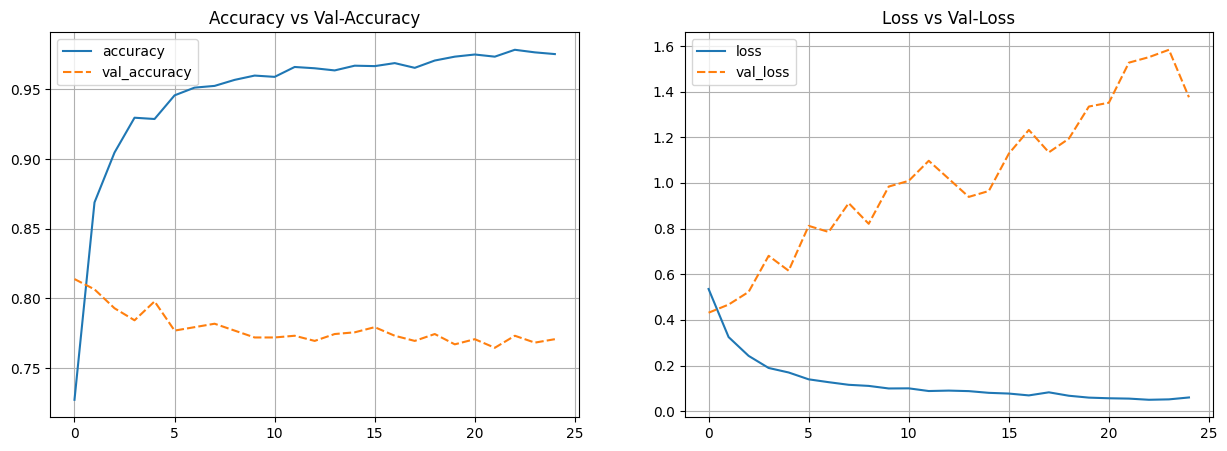

In [32]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

# LSTM Transfer Learning

In [33]:
# Download the Embedding Layer
hub_layer = tf_hub.KerasLayer("https://www.kaggle.com/models/google/nnlm/tensorFlow2/tf2-preview-id-dim128-with-normalization/1", output_shape=[128], 
                           input_shape=[], dtype=tf.string)

In [34]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((1, 128)))
# First Bidirectional LSTM Layer with return_sequences=True to pass 3D output to next LSTM layer
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.2))
# Second Bidirectional LSTM Layer
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.2))
# Output layer
model_lstm_2.add(Dense(2, activation='softmax'))
# Compile the model
model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 bidirectional (Bidirection  (None, 1, 64)             41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [35]:
earlystop = EarlyStopping(monitor='val_accuracy', patience= 4, restore_best_weights= True)

In [36]:
%%time
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), 
                                     callbacks=earlystop)

Epoch 1/50
102/102 [==============================] - 13s 32ms/step - loss: 0.6407 - accuracy: 0.6534 - val_loss: 0.5268 - val_accuracy: 0.7411
Epoch 2/50
102/102 [==============================] - 1s 10ms/step - loss: 0.4912 - accuracy: 0.7667 - val_loss: 0.4892 - val_accuracy: 0.7682
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.4776 - accuracy: 0.7750 - val_loss: 0.4757 - val_accuracy: 0.7756
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.4654 - accuracy: 0.7812 - val_loss: 0.4676 - val_accuracy: 0.7830
Epoch 5/50
102/102 [==============================] - 1s 7ms/step - loss: 0.4615 - accuracy: 0.7883 - val_loss: 0.4644 - val_accuracy: 0.7793
Epoch 6/50
102/102 [==============================] - 1s 6ms/step - loss: 0.4533 - accuracy: 0.7877 - val_loss: 0.4585 - val_accuracy: 0.7781
Epoch 7/50
102/102 [==============================] - 1s 8ms/step - loss: 0.4449 - accuracy: 0.7873 - val_loss: 0.4573 - val_accuracy: 0.7842
Epo

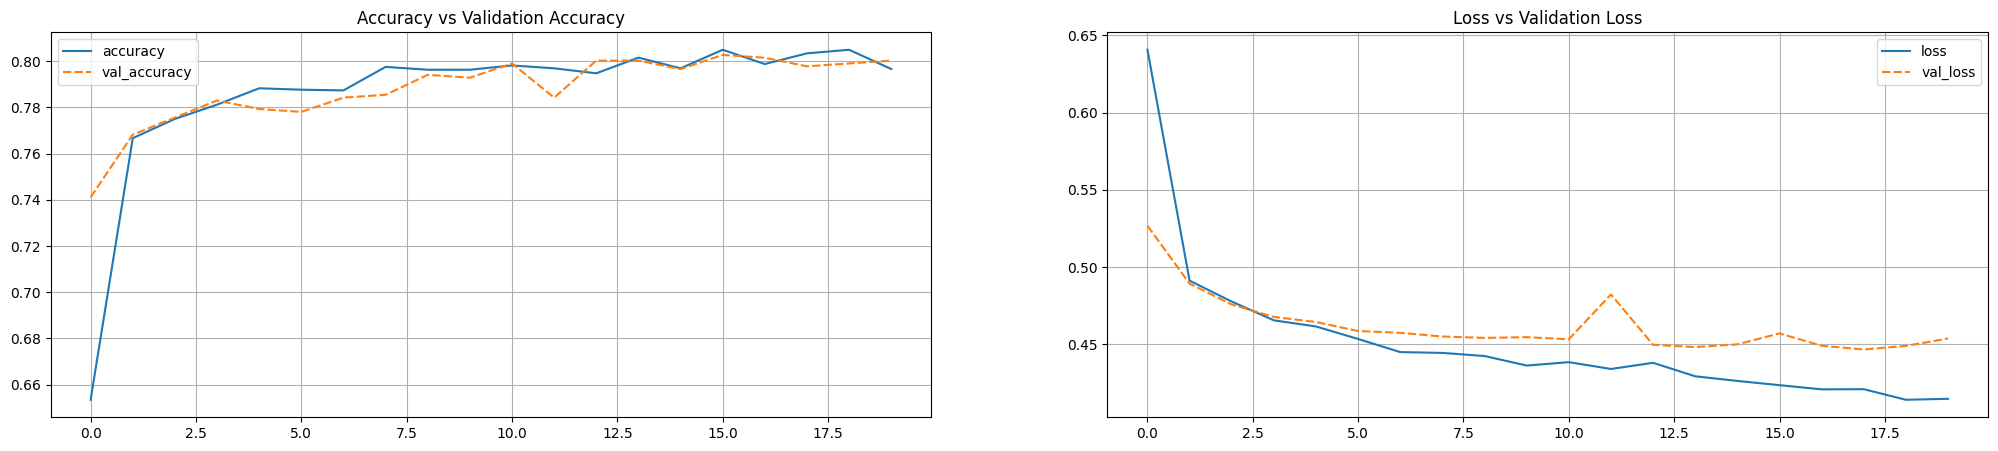

In [37]:
# Plot Training Results
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2.history.history)

# Plot Accuracy vs Validation Accuracy
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid(True)
plt.title('Accuracy vs Validation Accuracy')

# Plot Loss vs Validation Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid(True)
plt.title('Loss vs Validation Loss')

# Display the plots
plt.show()

In [38]:
y_pred = model_lstm_2.predict(X_test)
print("y_pred shape:", y_pred.shape)

32/32 [==============================] - 2s 4ms/step
y_pred shape: (1013, 2)


In [39]:
# Prediksi model
y_pred = model_lstm_2.predict(X_test)
# Periksa bentuk prediksi
print(f"Original y_pred shape: {y_pred.shape}")
# Jika output prediksi memiliki dimensi tambahan, ambil dimensi pertama
if y_pred.shape[1] == 2:  # Output dengan 2 kelas
    y_pred = y_pred[:, 1]  # Ambil probabilitas untuk kelas positif
# Konversi prediksi menjadi label biner (0 atau 1)
y_pred = np.where(y_pred >= 0.5, 1, 0)
# Pastikan y_test berbentuk 1D
y_test = y_test.ravel()
# Pastikan panjang y_test dan y_pred sama
if y_pred.shape[0] != y_test.shape[0]:
    print(f"Mismatch detected! Trimming predictions from {y_pred.shape[0]} to {y_test.shape[0]}.")
    y_pred = y_pred[:y_test.shape[0]]
# Cetak laporan klasifikasi
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 6ms/step
Original y_pred shape: (1013, 2)
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       507
           1       0.84      0.67      0.75       506

    accuracy                           0.77      1013
   macro avg       0.78      0.77      0.77      1013
weighted avg       0.78      0.77      0.77      1013



Text(95.72222222222221, 0.5, 'True Label')

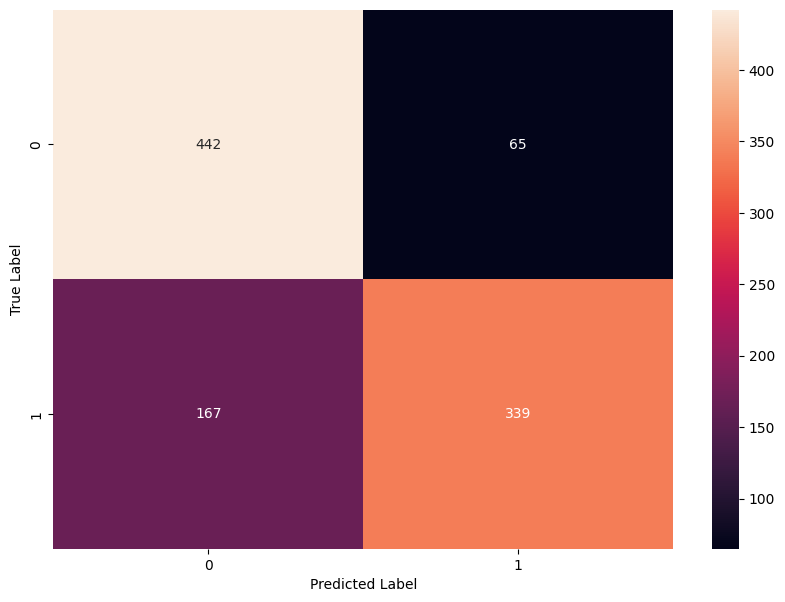

In [40]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,fmt = 'd')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Model Saving

In [41]:
# Freeze lstm model
model_lstm_2.trainable = False
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 bidirectional (Bidirection  (None, 1, 64)             41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [42]:
# Save lstm model
model_lstm_2.save('nlp_model.h5')